In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pre Processing :

In [ ]:
import requests
import pandas as pd


indicators = {
    'child_mortality': 'SH.DYN.MORT',
    'exports': 'NE.EXP.GNFS.ZS',
    'health': 'SH.XPD.CHEX.GD.ZS',
    'imports': 'NE.IMP.GNFS.ZS',
    'income': 'NY.GNP.PCAP.CD',
    'inflation': 'NY.GDP.DEFL.KD.ZG',
    'life_expectancy': 'SP.DYN.LE00.IN',
    'total_fertility': 'SP.DYN.TFRT.IN',
    'gdpp': 'NY.GDP.PCAP.CD',
    'literacy_rate':'SE.ADT.LITR.ZS'
}
base_url = "https://api.worldbank.org/v2/country/all/indicator/"


dataframes = []
for name, code in indicators.items():
    response = requests.get(f"{base_url}{code}?format=json&per_page=10000")
    if response.status_code == 200:
        try:
            records = response.json()[1]
            latest_records = {}
            for rec in records:
                if (
                    'country' in rec and 'value' in rec and rec['value'] is not None and
                    'id' in rec['country'] and len(rec['country']['id']) == 2
                ):
                    country = rec['country']['value']
                    year = int(rec['date'])
                    if country not in latest_records or year > latest_records[country]['date']:
                        latest_records[country] = {'country': country, 'date': year, 'value': rec['value']}


            df = pd.DataFrame([
                {'country': rec['country'], 'date': rec['date'], 'value': rec['value'], 'indicator': name}
                for rec in latest_records.values()
            ])
            dataframes.append(df)
        except (KeyError, IndexError) as e:
            print(f"Error processing indicator {name}: {e}")


if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df = combined_df.pivot_table(index='country', columns='indicator', values='value')
    combined_df.reset_index(inplace=True)
    combined_df.head()
else:
    print("No data was processed.")

1. **Country**: The name of the country.
2. **child_mort**: Death rate of children under 5 years of age, per 1,000 live births.
3. **exports**: Exports of goods and services per capita, given as a percentage of GDP per capita.
4. **health**: Total health expenditure per capita, expressed as a percentage of GDP per capita.
5. **imports**: Imports of goods and services per capita, given as a percentage of GDP per capita.
6. **income**: Net income per person.
7. **inflation**: The annual growth rate of total GDP, measured as a percentage.
8. **life_expectancy**: The average number of years a newborn is expected to live, assuming current mortality patterns.
9. **total_fer**: The number of children born to a woman, based on current age-fertility rates.
10. **gdpp**: GDP per capita, calculated as the total GDP divided by the total population.
11. **literacy_rate**: The percentage of the population aged 15 and above that can read and write.

In [ ]:
combined_df.head(2)

indicator,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788


In [ ]:
combined_df.shape

(156, 11)

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          156 non-null    object 
 1   child_mortality  143 non-null    float64
 2   exports          145 non-null    float64
 3   gdpp             153 non-null    float64
 4   health           140 non-null    float64
 5   imports          147 non-null    float64
 6   income           150 non-null    float64
 7   inflation        153 non-null    float64
 8   life_expectancy  154 non-null    float64
 9   literacy_rate    123 non-null    float64
 10  total_fertility  154 non-null    float64
dtypes: float64(10), object(1)
memory usage: 13.5+ KB


In [ ]:
countries_to_remove = [
    'Heavily indebted poor countries (HIPC)', 'Early-demographic dividend',
    'Fragile and conflict affected situations', 'High income', 'Late-demographic dividend',
    'Low & middle income', 'Low income', 'Lower middle income',
    'Middle income', 'OECD members', 'Other small states',
    'Post-demographic dividend', 'Pre-demographic dividend', 'Small states',
    'Upper middle income', 'World'
]


df = combined_df[~combined_df['country'].isin(countries_to_remove)]
df.head()


indicator,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788
2,Africa Western and Central,91.603446,NaN,1584.333285,4.140713,NaN,1702.074629,3.386691,57.626176,60.505550,4.897322
3,Albania,9.400000,39.623396,8367.775731,7.267318,44.914895,7570.000000,4.553083,76.833000,98.500000,1.376000
4,Algeria,21.800000,25.167521,5260.206250,5.528343,21.028373,4960.000000,-2.258254,77.129000,81.407837,2.829000


In [ ]:
df.shape

(140, 11)

In [ ]:
df.isnull().sum()

,0
indicator,
country,0
child_mortality,13
exports,10
gdpp,3
health,16
imports,9
income,6
inflation,3
life_expectancy,2


**Handled the missing value using the knn imputer:**

*Use KNN imputation to replace missing values based on the most similar countries (neighbors) based on other available indicators. This method finds similar countries based on available indicators and fills missing values with averages from these "neighbor" countries.* <br>
*This approach can capture complex patterns between countries and might yield accurate imputations.*

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd


non_numeric_cols = df.select_dtypes(exclude=['number'])
numeric_cols = df.select_dtypes(include=['number'])


scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(numeric_cols)


imputer = KNNImputer(n_neighbors=5)
imputed_numeric_data = imputer.fit_transform(scaled_numeric_data)


imputed_numeric_data = scaler.inverse_transform(imputed_numeric_data)


df_num= pd.DataFrame(imputed_numeric_data, columns=numeric_cols.columns)
df = pd.concat([non_numeric_cols.reset_index(drop=True), df_num], axis=1)


In [ ]:
df.isnull().sum()

,0
indicator,
country,0
child_mortality,0
exports,0
gdpp,0
health,0
imports,0
income,0
inflation,0
life_expectancy,0


In [ ]:
df.describe()

indicator,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,25.048977,40.239520,19315.911658,7.100919,44.189727,18466.972005,6.072485,72.496341,87.427834,2.421330
std,24.827173,26.332102,24197.488341,3.042927,25.482243,23103.115782,13.082256,7.575165,15.849410,1.206982
min,1.900000,5.263385,199.580760,2.204867,13.992409,230.000000,-18.189413,52.997000,27.280001,0.701000
25%,7.275000,23.617499,2678.872466,5.072737,27.086352,2890.000000,2.806304,66.450250,80.284998,1.530000
50%,14.899787,34.400219,8452.573971,6.814235,35.507361,7945.538866,4.711467,73.651405,95.250000,1.877500
75%,37.125000,50.634077,29184.090710,9.030426,56.082488,27142.500000,6.609305,78.198750,98.105001,2.930000
max,102.900000,176.215547,123091.123516,21.827950,175.375185,134640.000000,133.839867,83.996341,100.000000,6.215000


# DATA VISUALIZATION

In [ ]:
df.head(5)

indicator,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788
2,Africa Western and Central,91.603446,27.522371,1584.333285,4.140713,27.457559,1702.074629,3.386691,57.626176,60.505550,4.897322
3,Albania,9.400000,39.623396,8367.775731,7.267318,44.914895,7570.000000,4.553083,76.833000,98.500000,1.376000
4,Algeria,21.800000,25.167521,5260.206250,5.528343,21.028373,4960.000000,-2.258254,77.129000,81.407837,2.829000


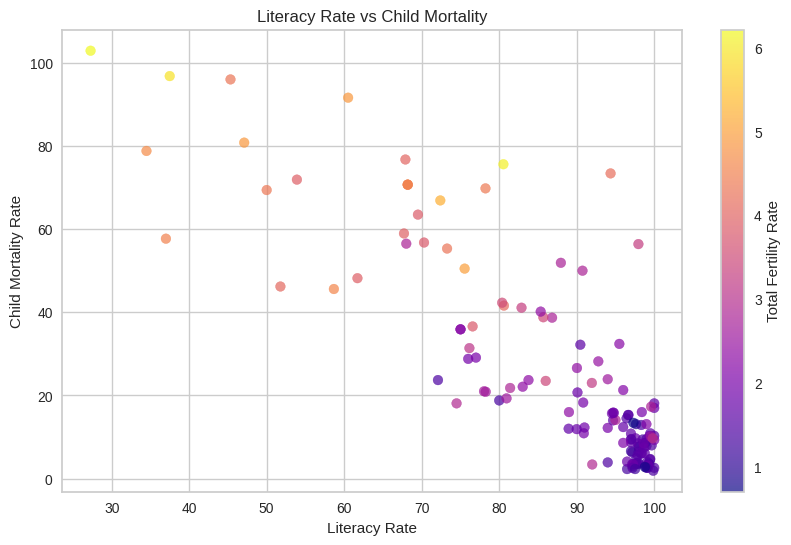

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['literacy_rate'], df['child_mortality'], c=df['total_fertility'], cmap='plasma', alpha=0.7)
plt.xlabel('Literacy Rate')
plt.ylabel('Child Mortality Rate')
plt.title('Literacy Rate vs Child Mortality')
plt.colorbar(label='Total Fertility Rate')

*The scatter plot suggests a **strong negative correlation** between literacy rate and child mortality rate. As literacy rate increases, child mortality rate generally decreases. This indicates that higher levels of education may lead to better healthcare practices and improved child survival rates.*

*However, most countries with high levels of literacy rates to have lower total fertility rate.*

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=df['literacy_rate'],
    y=df['child_mortality'],
    z=df['total_fertility'],
    mode='markers',
    marker=dict(
        size=6,
        color=df['total_fertility'],
        colorscale='plasma',
        opacity=0.7
    )
)])

fig.update_layout(scene = dict(
    xaxis_title='Literacy Rate',
    yaxis_title='Child Mortality Rate',
    zaxis_title='Total Fertility Rate'
))

fig.show()

<ipython-input-13-35c842dad3f2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='income_level', y='child_mortality', palette='pastel')


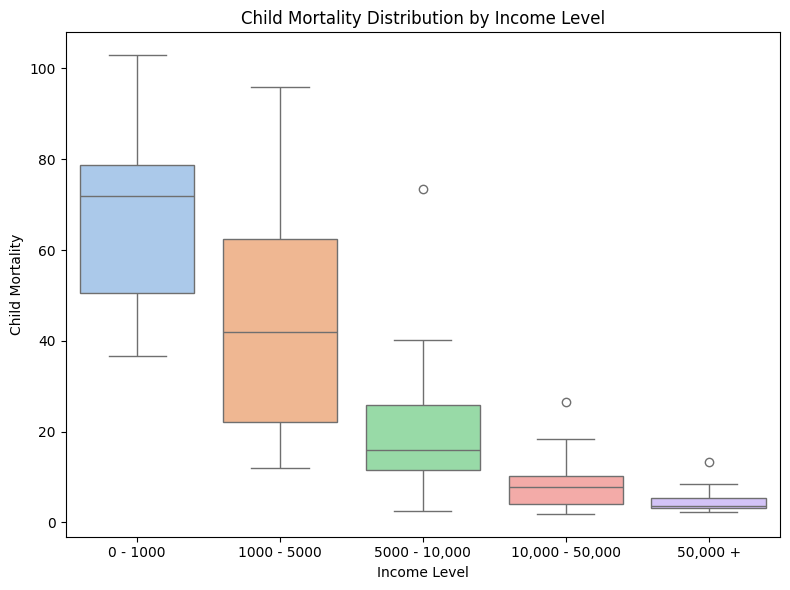

In [ ]:
df['income_level'] = pd.cut(df['income'], bins=[0, 1000, 5000, 10000, 50000, np.inf],
                            labels=['0 - 1000', '1000 - 5000', '5000 - 10,000', '10,000 - 50,000', '50,000 +'])
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='income_level', y='child_mortality', palette='pastel')
plt.title('Child Mortality Distribution by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Child Mortality')
plt.tight_layout()
plt.show()


*The median child mortality rate decreases as income level increases. The spread of the data, represented by the box and whiskers, also decreases with increasing income levels. This suggests that wealthier countries have a more consistent and lower child mortality rate.*

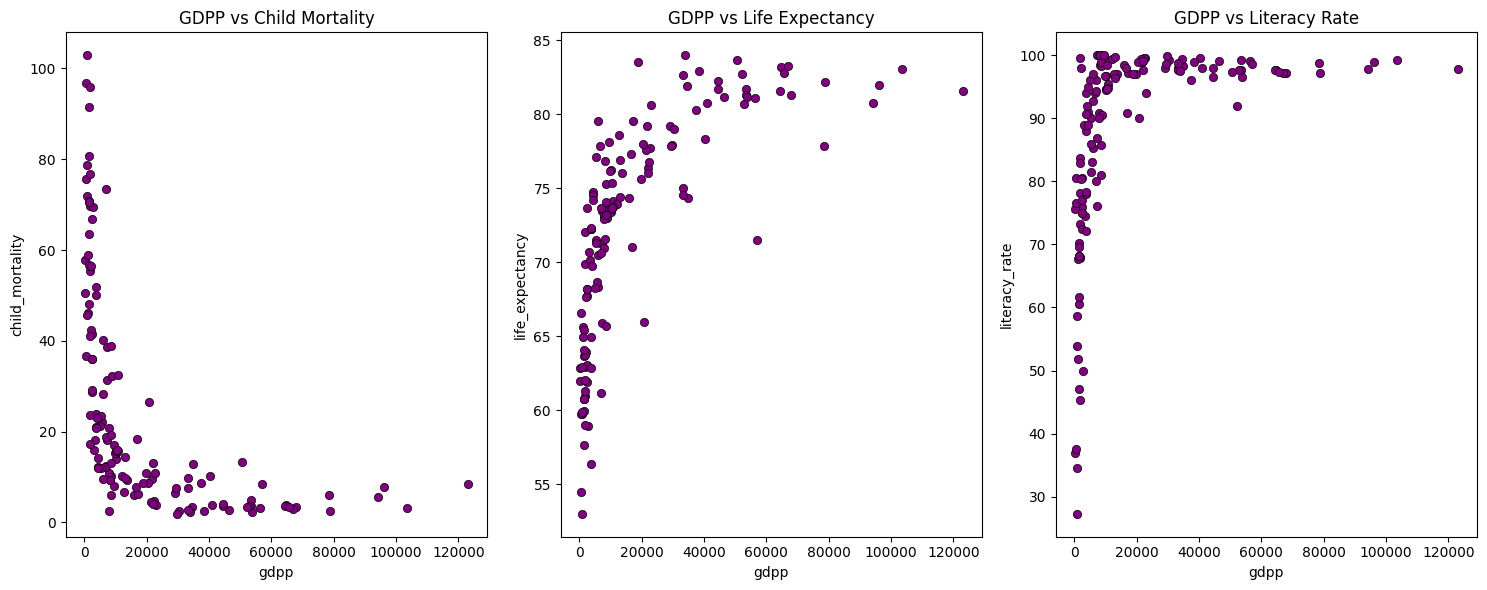

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='gdpp', y='child_mortality', color='purple', edgecolor='black')
plt.title('GDPP vs Child Mortality')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='gdpp', y='life_expectancy', color='purple', edgecolor='black')
plt.title('GDPP vs Life Expectancy')

plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='gdpp', y='literacy_rate', color='purple', edgecolor='black')
plt.title('GDPP vs Literacy Rate')
plt.tight_layout()
plt.show()


*The scatter plots reveal strong correlations between GDP per capita and key socio-economic indicators. Higher GDP per capita is associated with lower child mortality, higher life expectancy, and higher literacy rates. These findings highlight the significant impact of economic development on health, education, and overall well-being.*

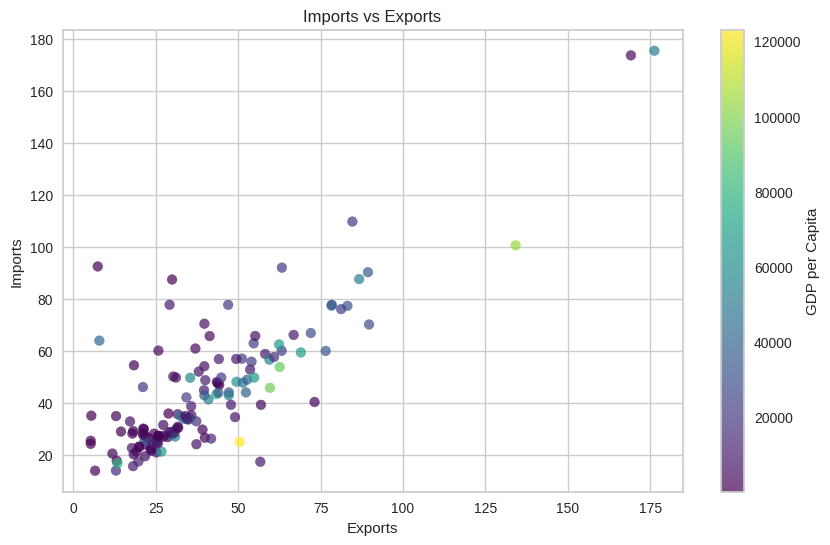

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['exports'], df['imports'], c=df['gdpp'], cmap='viridis', alpha=0.7)
plt.xlabel('Exports')
plt.ylabel('Imports')
plt.title('Imports vs Exports')
plt.colorbar(label='GDP per Capita')

*There seems to be a **positive correlation** between imports and exports. Further, countries with higher GDP per capita tend to have both higher imports and exports. This suggests that wealthier countries engage in more trade.*

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=df['exports'],
    y=df['imports'],
    z=df['gdpp'],
    mode='markers',
    marker=dict(
        size=6,
        color=df['gdpp'],  # Set color based on GDP per capita
        colorscale='viridis',
        opacity=0.7
    )
)])

fig.update_layout(scene = dict(
    xaxis_title='Exports',
    yaxis_title='Imports',
    zaxis_title='GDP per Capita'
))

fig.show()

*The clustering near the lower GDP per capita values reflects countries with limited trade activity, potentially signifying a need for economic support.*

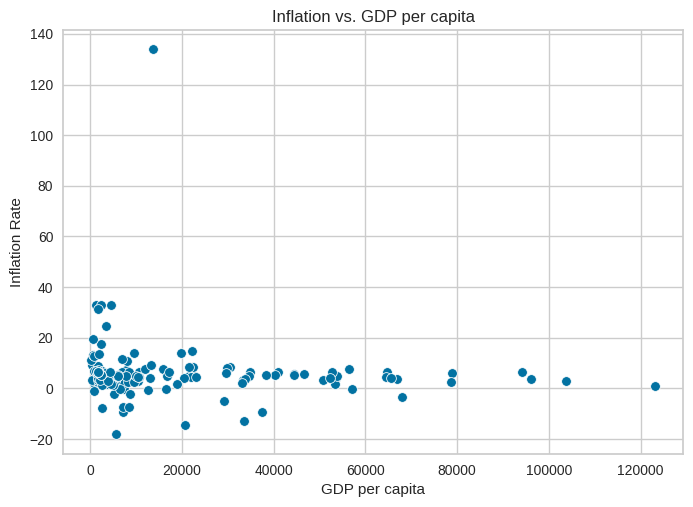

In [ ]:
# 1. Inflation vs. GDP per capita
sns.scatterplot(x='gdpp', y='inflation', data=df)
plt.title('Inflation vs. GDP per capita')
plt.xlabel('GDP per capita')
plt.ylabel('Inflation Rate')
plt.show()

*From the graph, it is evident that countries with higher GDP per capita generally experience lower and more stable inflation rates, clustering near the 0% mark. However, countries with lower GDP per capita show a wider range of inflation rates, including extreme outliers. This suggests that economic stability, reflected in GDP, is closely linked to inflation control.*

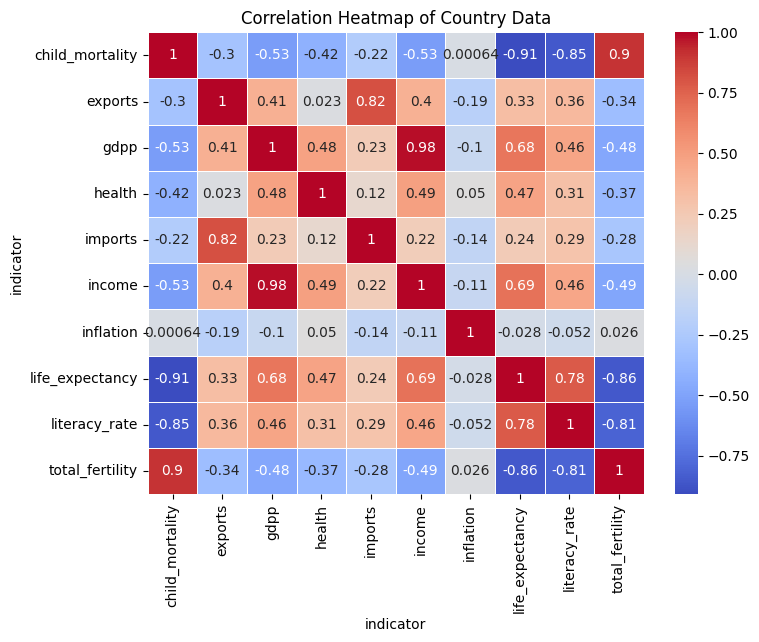

In [ ]:
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Country Data')
plt.show()

* **Strong Positive Correlations:** *We see that **GDPP** is strongly positively correlated with **life expectancy** and **literacy rate**, indicating that wealthier countries tend to have better health and education outcomes.*
* **Strong Negative Correlations:** *The **child mortality rate** is strongly negatively correlated with **life expectancy** and **literacy rate**, suggesting that as education and healthcare improve, **child mortality** rates decrease.*
* **Moderate Correlations:** *There are moderate positive correlations between **GDPP** and **exports/imports**, indicating that wealthier countries tend to engage more in international trade.*

# Cluster Analysis

## Cluster Selection // determining the optimal number of clusters:

**Feature Extraction Using PCA:**

In [ ]:
df_scaled = scaler.fit_transform(df.drop(['country'], axis=1))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca)

In [ ]:
pca.explained_variance_ratio_

array([0.5108617 , 0.16169782, 0.11793172, 0.09287424, 0.06384337,
       0.02084196])

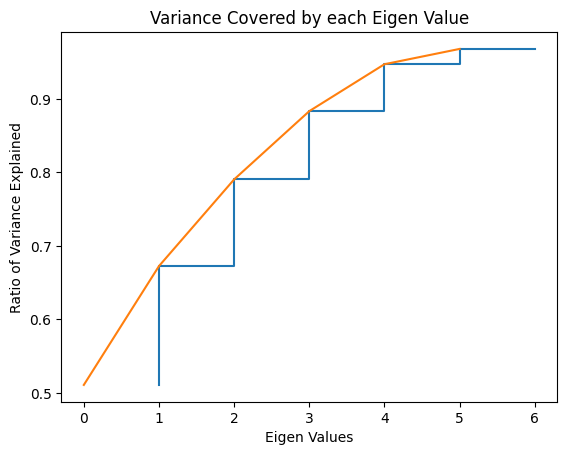

In [ ]:
plt.step(list(range(1,7)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Eigen Values')
plt.ylabel('Ratio of Variance Explained')
plt.title('Variance Covered by each Eigen Value')
plt.show()

In [ ]:
df_pca.head()

,0,1,2,3,4,5
0,-2.399842,-0.636583,3.029951,1.861830,4.684757,-1.062904
1,-2.804381,-0.027638,0.500179,0.180138,0.001303,0.414019
2,-4.253232,0.798870,1.324403,0.015925,-0.339355,0.348241
3,0.763633,-0.331434,-1.202375,-0.372194,0.328758,-0.107091
4,-0.783009,-0.618317,-0.357710,-1.071777,-0.157454,-0.487161


**Deciding the number of clusters -**

1)  Elbow Method -

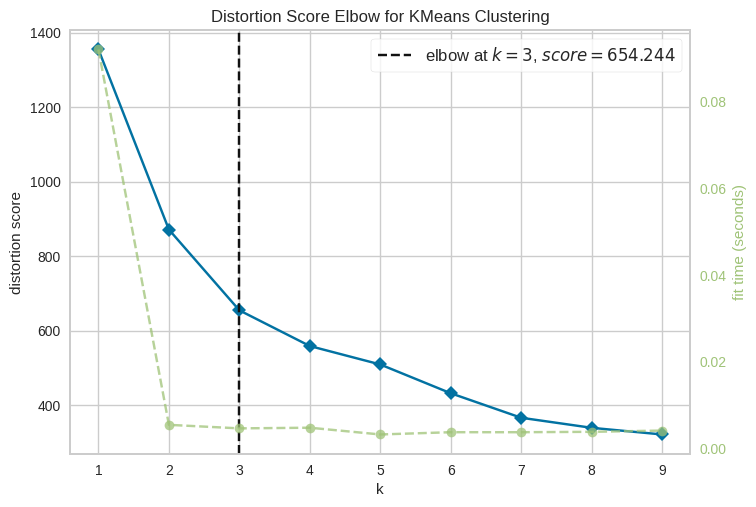

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10))
visualize.fit(df_pca)
visualize.poof()

*The elbow plot suggests that 3 clusters is the optimal number of clusters for this dataset.*

*The distortion score drops significantly from 2 to 3 clusters, and then the decrease becomes less pronounced, indicating a clear elbow point at k=3.*

2) Silhouette Score -

For n_clusters = 2, the average silhouette score is 0.35264914288177707
For n_clusters = 3, the average silhouette score is 0.34155012096527804
For n_clusters = 4, the average silhouette score is 0.3612073171781257
For n_clusters = 5, the average silhouette score is 0.3642111603467753
For n_clusters = 6, the average silhouette score is 0.27511093777733364
For n_clusters = 7, the average silhouette score is 0.2711663670034828
For n_clusters = 8, the average silhouette score is 0.25381184144151214
For n_clusters = 9, the average silhouette score is 0.25459113595410826
For n_clusters = 10, the average silhouette score is 0.2283291289829553


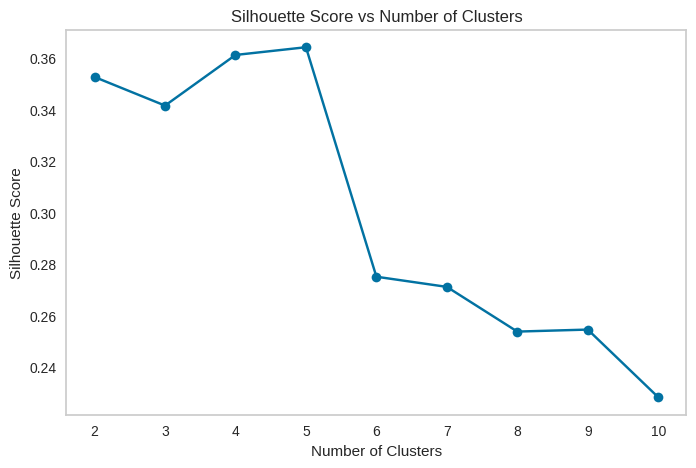

The optimal number of clusters based on silhouette score is: 5


In [ ]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 11)
silhouette_scores = []


for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette score is {silhouette_avg}")


plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.grid()
plt.show()

optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters based on silhouette score is: {optimal_clusters}")

**Plotting 2 PC for clusters 3 and 5 :**

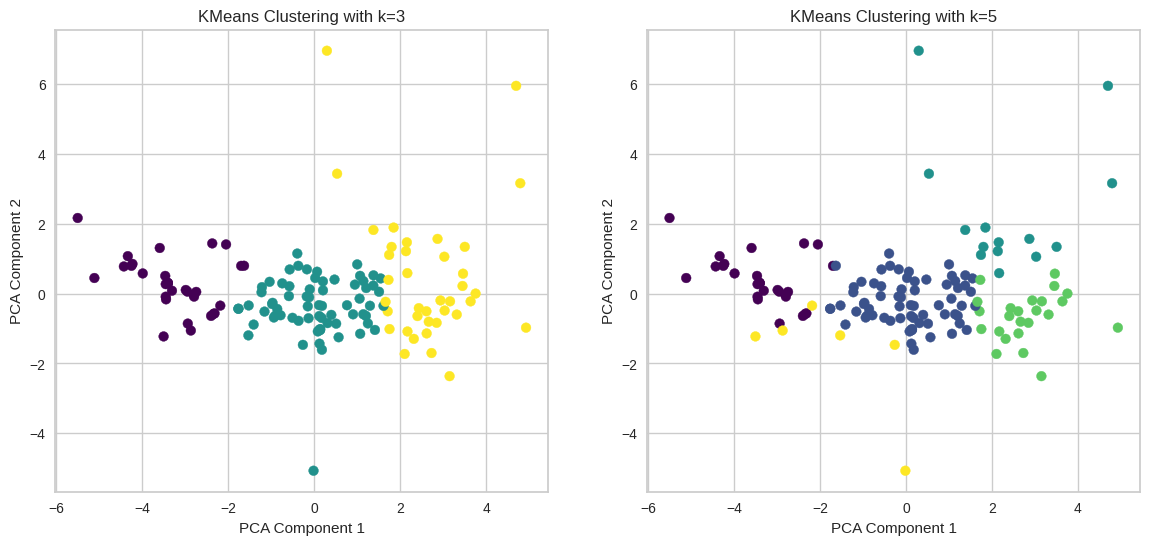

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, k in enumerate([3, 5]):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_pca)
    axes[i].scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=cluster_labels, cmap='viridis', marker='o')
    axes[i].set_title(f'KMeans Clustering with k={k}')
    axes[i].set_xlabel('PCA Component 1')
    axes[i].set_ylabel('PCA Component 2')

plt.show()


* **k=3:** *The data forms three broad and relatively well-separated groups. This approach gives a high-level categorization, likely reflecting large socio-economic distinctions among countries.*

* **k=5:** *The clusters overlap slightly more, and some clusters are tightly packed, particularly near the center, suggesting that there may not be strong distinctions between these additional clusters*

***Hence, we decided to go ahead with 3 clusters.***

##KMEANS :

In [ ]:
df_k=df.copy()

In [ ]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(df_pca)
df_k['KMean_labels']=model.labels_

In [ ]:
df_k.head()

indicator,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility,KMean_labels
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000,2
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788,2
2,Africa Western and Central,91.603446,27.522371,1584.333285,4.140713,27.457559,1702.074629,3.386691,57.626176,60.505550,4.897322,2
3,Albania,9.400000,39.623396,8367.775731,7.267318,44.914895,7570.000000,4.553083,76.833000,98.500000,1.376000,1
4,Algeria,21.800000,25.167521,5260.206250,5.528343,21.028373,4960.000000,-2.258254,77.129000,81.407837,2.829000,1


In [ ]:
df_k['KMean_labels'].value_counts()

,count
KMean_labels,
1,76
2,32
0,32


<ipython-input-46-ee33cbf42ada>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'KMean_labels', y = 'gdpp', data  = df_k,palette='pastel');
<ipython-input-46-ee33cbf42ada>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'KMean_labels', y = 'life_expectancy', data  = df_k,palette='pastel');


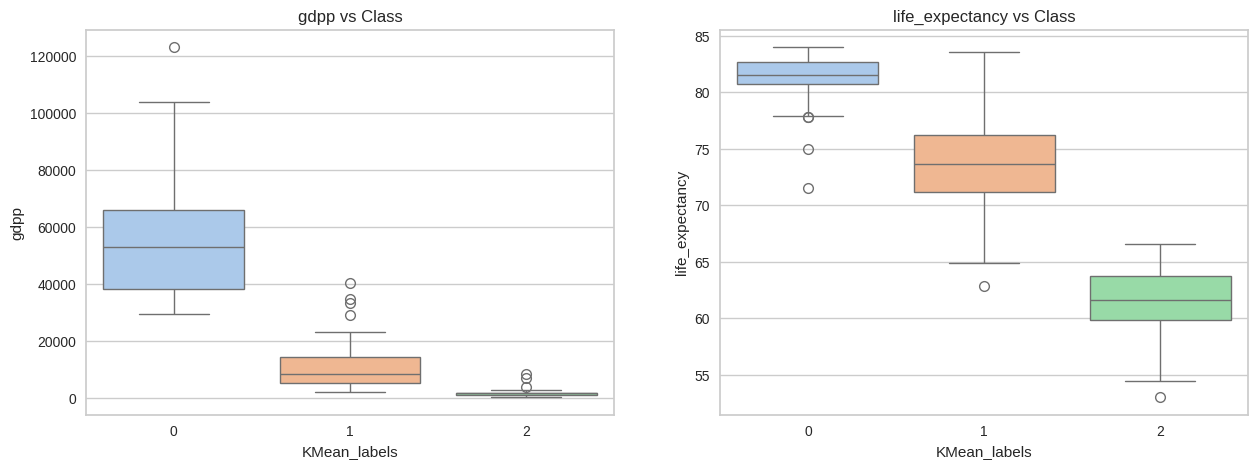

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'KMean_labels', y = 'gdpp', data  = df_k,palette='pastel');
plt.title('gdpp vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'KMean_labels', y = 'life_expectancy', data  = df_k,palette='pastel');
plt.title('life_expectancy vs Class')

plt.show()



1. **Cluster 0**:
   -  **High gdpp** and **high life expectancy**
   - This cluster likely represents **"high Socioeconomic Status"** countries, with higher gdpp and high life expectancy.

2. **Cluster 1**:
   - **Moderate gdpp** and **moderate life_expectancy** levels.
   - This cluster could represent **"Middle Socioeconomic Status"** countries, with moderate outcomes in both gdpp and life_expectancy.

3. **Cluster 2**:
   - **Low gdpp** and **low life_Expectancy**.
   - This cluster is likely **"low Socioeconomic Status"**, with low gdpp and lower life expectancy.*

**CALINSKI_HARABASZ_SCORE** : *measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion*

In [ ]:
from sklearn.metrics import calinski_harabasz_score
features= df_k.drop(columns=['country', 'KMean_labels'])
kmeans_labels = df_k['KMean_labels']

kmeans_ch_score = calinski_harabasz_score(features, kmeans_labels)
print(f"Calinski-Harabasz Score for KMeans: {kmeans_ch_score}")

Calinski-Harabasz Score for KMeans: 192.7133894714456


In [ ]:
df_k['KMean_labels'].loc[df_k['KMean_labels'] == 0] = 'High Socioeconomic status'
df_k['KMean_labels'].loc[df_k['KMean_labels'] == 1] = 'Middle Socioeconomic status'
df_k['KMean_labels'].loc[df_k['KMean_labels'] == 2] = 'low Socioeconomic status'

<ipython-input-48-c4658b56184d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k['KMean_labels'].loc[df_k['KMean_labels'] == 0] = 'High Socioeconomic status'
<ipython-input-48-c4658b56184d>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High Socioeconomic status' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_k['KMean_labels'].loc[df_k['KMean_labels'] == 0] = 'High Socioeconomic status'


In [ ]:
!pip install plotly
import plotly.express as px

In [ ]:
fig = px.choropleth(df_k[['country','KMean_labels']],
                    locationmode = 'country names',
                    locations = 'country',
                    title = 'SOCIO-ECONOMIC STATUS',
                    color = df_k['KMean_labels'],
                    color_discrete_map = {'low Socioeconomic status':'red',
                                        'High Socioeconomic status':'Green',
                                        'Middle Socioeconomic status':'Yellow'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

##DBSCAN :

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

eps: 0.1, min_samples: 2, silhouette score: -0.32939088001483274
eps: 0.1, min_samples: 3, silhouette score: -0.34594927926277097
eps: 0.30000000000000004, min_samples: 2, silhouette score: -0.3786438410742002
eps: 0.30000000000000004, min_samples: 3, silhouette score: -0.3229330392713133
eps: 0.5000000000000001, min_samples: 2, silhouette score: -0.3077032982864492
eps: 0.5000000000000001, min_samples: 3, silhouette score: -0.3397786199034019
eps: 0.5000000000000001, min_samples: 4, silhouette score: -0.21214250348683414
eps: 0.5000000000000001, min_samples: 5, silhouette score: -0.21214250348683414
eps: 0.7000000000000001, min_samples: 2, silhouette score: -0.15347343083385037
eps: 0.7000000000000001, min_samples: 3, silhouette score: -0.16773377458008806
eps: 0.7000000000000001, min_samples: 4, silhouette score: -0.22924638580107687
eps: 0.7000000000000001, min_samples: 5, silhouette score: -0.2346771501169524
eps: 0.7000000000000001, min_samples: 6, silhouette score: -0.13333694802

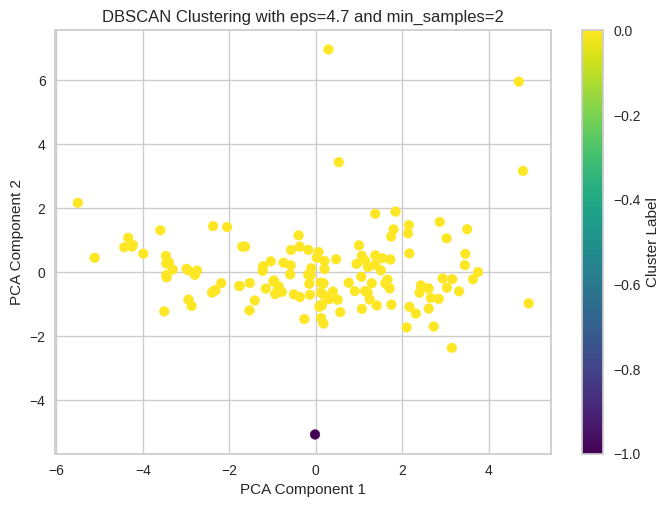

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np


#Finding the optimal values for eps and min_samples :

eps_values = np.arange(0.1, 5.0, 0.2)
min_samples_values = range(2, 10)
best_silhouette_score = -1
best_eps = None
best_min_samples = None


for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(df_pca)


        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(df_pca, cluster_labels)
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {silhouette_avg}")


            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

if best_eps is not None and best_min_samples is not None:
    print(f"\nBest eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_silhouette_score}")

    # Applying DBSCAN with best parameters
    dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan_best.fit_predict(df_pca)

    # Visualizing the DBSCAN clustering results
    import matplotlib.pyplot as plt

    plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=dbscan_labels, cmap='viridis')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"DBSCAN Clustering with eps={best_eps} and min_samples={best_min_samples}")
    plt.colorbar(label="Cluster Label")
    plt.show()
else:
    print("No suitable clustering parameters found. Try expanding the parameter range further.")


*As the data has no clear dense regions and points are spread out evenly, DBSCAN is treating all the points as part of a single cluster.*

##Hierarchical :

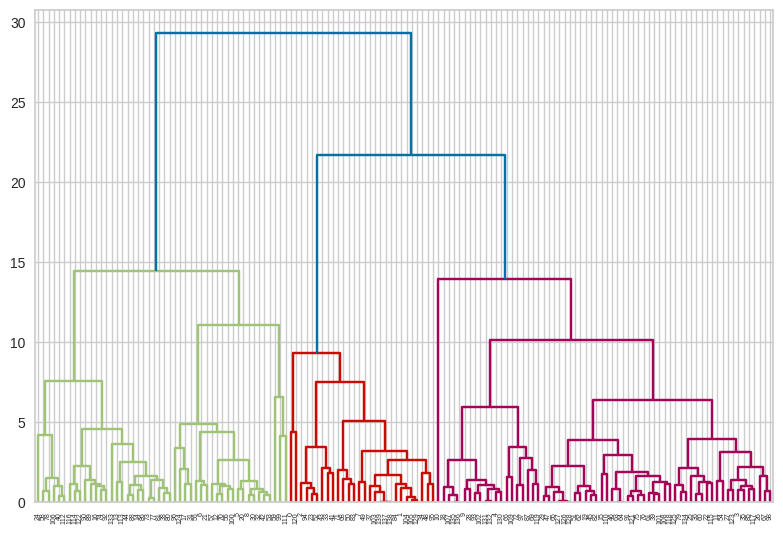

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_data = linkage(df_pca, method = 'ward', metric = 'euclidean')
dendrogram(linkage_data)
plt.tight_layout()
plt.show()

In [ ]:
df_h=df.copy()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
labels = hierarchical_cluster.fit(df_pca)

pred_agc = pd.Series(hierarchical_cluster.labels_)
df_h['hc_labels'] = pred_agc

In [ ]:
df_h['hc_labels'].value_counts()

,count
hc_labels,
1,64
0,48
2,28


In [ ]:
df_h.head(2)

indicator,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility,hc_labels
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000,2
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788,2


<ipython-input-334-0a4bdbfe1687>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-334-0a4bdbfe1687>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




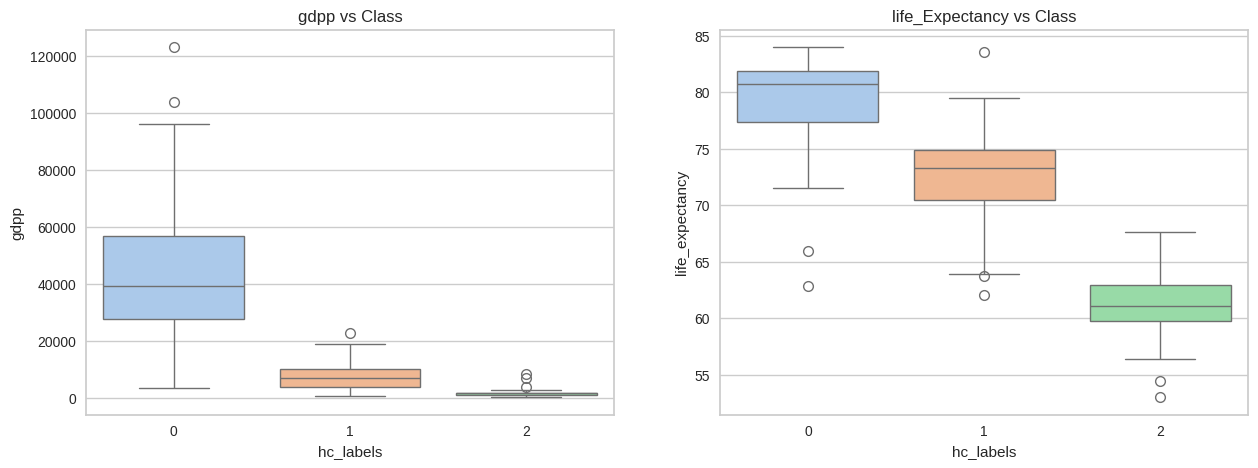

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(x = 'hc_labels', y = 'gdpp', data  = df_h,palette='pastel');
plt.title('gdpp vs Class')

plt.subplot(1,2,2)
sns.boxplot(x = 'hc_labels', y = 'life_expectancy', data  = df_h,palette='pastel');
plt.title('life_Expectancy vs Class')

plt.show()



1. **Cluster 0**:
   - **High gdpp** and **high life expectancy**
   - This cluster likely represents **"high Socioeconomic Status"** countries, with higher gdpp and high life expectancy.

2. **Cluster 1**:
   - **Moderate gdpp** and **moderate life_expectancy** levels.
   - This cluster could represent **"Middle Socioeconomic Status"** countries, with moderate outcomes in both gdpp and life_expectancy.

3. **Cluster 2**:
   - **Low gdpp** and **low life_Expectancy**.
   - This cluster is likely **"low Socioeconomic Status"**, with low gdpp and lower life expectancy.

**CALINSKI HARABASZ SCORE :**

In [ ]:
from sklearn.metrics import calinski_harabasz_score
features= df_h.drop(columns=['country', 'hc_labels'])
hc_labels = df_h['hc_labels']

kmeans_ch_score = calinski_harabasz_score(features, hc_labels)
print(f"Calinski-Harabasz Score for Hierarchical: {kmeans_ch_score}")

Calinski-Harabasz Score for KMeans: 106.50307547861446


In [ ]:
df_h['hc_labels'].loc[df_h['hc_labels'] == 0] = 'High Socioeconomic status'
df_h['hc_labels'].loc[df_h['hc_labels']== 1] = 'Middle Socioeconomic status'
df_h['hc_labels'].loc[df_h['hc_labels']== 2] = 'low Socioeconomic status'

<ipython-input-336-bce952b470dc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-336-bce952b470dc>:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High Socioeconomic status' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [ ]:
fig = px.choropleth(df_h[['country','hc_labels']],
                    locationmode = 'country names',
                    locations = 'country',
                    title = 'SOCIO-ECONOMIC STATUS',
                    color = df_h['hc_labels'],
                    color_discrete_map = {'low Socioeconomic status':'red',
                                        'High Socioeconomic status':'Green',
                                        'Middle Socioeconomic status':'Yellow'}
                   )
fig.update_geos(fitbounds = "locations", visible = True)
fig.update_layout(legend_title_text = 'Labels',legend_title_side = 'top',title_pad_l = 260,title_y = 0.86)
fig.show(engine = 'kaleido')

##KMeans or Hierarchical :

*Since the **Calinski-Harabasz score** for **KMeans** is higher than that for **hierarchical clustering**, it suggests that KMeans produces more well-defined and distinct clusters compared to hierarchical clustering.*

*To further assess the realism of the clusters, we incorporated the latest available **HDI codes** for various countries into our dataset. We then constructed a **contingency table** which helped us to validate their practical relevance.*

In [ ]:
hdi=pd.read_csv("/content/hdi_data.csv",encoding='latin-1')

In [ ]:
hdi.head()

,country,hdicode
0,Afghanistan,Low
1,Albania,High
2,Algeria,High
3,Andorra,Very High
4,Angola,Medium


***Merged it with Kmeans :***

In [ ]:
df_merged_k = pd.merge(df_k, hdi, on='country', how='left')
df_merged_k.head()

,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility,KMean_labels,hdicode
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000,low Socioeconomic status,Low
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788,low Socioeconomic status,NaN
2,Africa Western and Central,91.603446,27.522371,1584.333285,4.140713,27.457559,1702.074629,3.386691,57.626176,60.505550,4.897322,low Socioeconomic status,NaN
3,Albania,9.400000,39.623396,8367.775731,7.267318,44.914895,7570.000000,4.553083,76.833000,98.500000,1.376000,Middle Socioeconomic status,High
4,Algeria,21.800000,25.167521,5260.206250,5.528343,21.028373,4960.000000,-2.258254,77.129000,81.407837,2.829000,Middle Socioeconomic status,High


In [ ]:
contingency_table = pd.crosstab(df_merged_k['KMean_labels'], df_merged_k['hdicode'])
contingency_table

hdicode,High,Low,Medium,Very High
KMean_labels,,,,
High Socioeconomic status,0,0,0,18
Middle Socioeconomic status,21,1,10,13
low Socioeconomic status,0,10,8,0


***Merged it with Hierarchical :***

In [ ]:
df_merged_h = pd.merge(df_h, hdi, on='country', how='left')
df_merged_h.head()


,country,child_mortality,exports,gdpp,health,imports,income,inflation,life_expectancy,literacy_rate,total_fertility,hc_labels,hdicode
0,Afghanistan,57.700000,18.380042,352.603733,21.827950,54.505427,360.000000,9.406239,62.879000,37.000000,4.523000,low Socioeconomic status,Low
1,Africa Eastern and Southern,55.324537,24.503160,1672.505957,5.865553,28.248490,1601.589297,8.770823,62.899031,73.275108,4.288788,low Socioeconomic status,NaN
2,Africa Western and Central,91.603446,27.522371,1584.333285,4.140713,27.457559,1702.074629,3.386691,57.626176,60.505550,4.897322,low Socioeconomic status,NaN
3,Albania,9.400000,39.623396,8367.775731,7.267318,44.914895,7570.000000,4.553083,76.833000,98.500000,1.376000,Middle Socioeconomic status,High
4,Algeria,21.800000,25.167521,5260.206250,5.528343,21.028373,4960.000000,-2.258254,77.129000,81.407837,2.829000,Middle Socioeconomic status,High


In [ ]:
contingency_table = pd.crosstab(df_merged_h['hc_labels'], df_merged_h['hdicode'])
contingency_table

hdicode,High,Low,Medium,Very High
hc_labels,,,,
High Socioeconomic status,2,1,0,25
Middle Socioeconomic status,19,2,12,6
low Socioeconomic status,0,8,6,0


 Comparison with KMeans:
- **High Socioeconomic Cluster**:
  - KMeans provided a cleaner separation for the **Very High HDI** cluster, without including countries from lower HDI categories.
  - Hierarchical clustering introduces more noise, with countries from **High HDI** and **Low HDI** entering the **High Socioeconomic** cluster.

- **Middle Socioeconomic Cluster**:
  - Both methods show this cluster spans multiple HDI categories.
  - Hierarchical clustering distributes more countries to **Medium HDI** compared to KMeans.

- **Low Socioeconomic Cluster**:
  - Both methods align well with **Low** and **Medium HDI**, showing consistency.

---

- **KMeans** seems better for the **High Socioeconomic Cluster** because it more clearly separates the **Very High HDI** countries.
- **Hierarchical Clustering** has a similar performance for the **Low Socioeconomic Cluster**, but it is noisier for the **High Socioeconomic Cluster**.

---

Through the Calinski-Harabasz score and the contingency table, we can conclude
that KMeans performs better for this dataset, effectively clustering countries based on their socio-economic background.
This unsupervised approach offers several advantages:

1. **Policy Insights**: It helps policymakers identify countries with similar socio-economic characteristics, enabling targeted interventions or collaborative efforts.
   
2. **Resource Allocation**: By grouping countries with similar needs, it can assist in the efficient allocation of international aid or development programs.
